## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果


In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.
/home/wan-chu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/wan-chu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/wan-chu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/wan-chu/.local/lib/python3.6/site-packages/tensorflow/py

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [29]:
from keras.layers import BatchNormalization, Activation, Dense, Input, Dropout
def build_mlp(input_shape, drp_ratio=.2, output_units=10, num_neurons=[512, 256, 128]):
    """Code Here
    建立你的神經網路
    """
    input_layer = Input(input_shape)
    for i, n_units in enumerate(num_neurons):
        if i ==0:
            x=BatchNormalization()(input_layer)
            x=Dense(units=n_units)(x)
            x=Activation('relu')(x)
            x=Dropout(drp_ratio)(x)
        else:
            x=Dense(units=n_units)(x)
            x=BatchNormalization()(x)
            x=Activation('relu')(x)
            x=Dropout(drp_ratio)(x)
            
        out = Dense(units=output_units, activation="softmax", name="output")(x)
        
        model = keras.models.Model(inputs=[input_layer], outputs=[out])
        
    return model

In [30]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [33]:
import tensorflow as tf
import keras.backend as K

"""Code Here
撰寫一個 loss function, 使其可以結合 focal loss 與 crossentropy loss
"""
def combined_loss(alpha=4.,gamma=2., ce_w=.3):
    """Define the customized loss."""
    gamma=float(gamma)
    alpha=float(alpha)
    ce_w=float(ce_w)
    def focal_loss_mixed(y_true, y_pred):
        epsilon=1e-8
        y_true=tf.convert_to_tensor(y_true,tf.float32)
        y_pred=tf.convert_to_tensor(y_pred,tf.float32)
        
        model_out=tf.add(y_pred,epsilon)
        ce=tf.multiply(y_true, -tf.log(model_out))
        weight=tf.multiply(y_true,tf.pow(tf.subtract(1.,model_out),gamma))
        fl=tf.multiply(alpha,tf.multiply(weight,ce))
        reduced_fl=tf.reduce_max(fl,axis=1)
        reduced_ce=tf.reduce_max(ce,axis=1)
        
        fl_ce_mixed=tf.add(tf.multiply(ce_w,reduced_fl),tf.multiply((1-ce_w),reduced_ce))

        return tf.reduce_mean(reduced_fl)

    return focal_loss_mixed
        
ce_weights_list = [0., 0.3, 0.5, 0.7, 1]

In [34]:
import itertools
results = {}

for i, ce_w in enumerate(ce_weights_list):
    print("Numbers of exp: %i, ce_weight: %.2f" % (i, ce_w))

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss=combined_loss(),metrics=['accuracy'],optimizer=optimizer)
    """Code Here
    將自定義的 loss function 加入模型
    """

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, ce_weight: 0.00
Model: "model_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
batch_normalization_37 (Batc (None, 3072)              12288     
_________________________________________________________________
dense_70 (Dense)             (None, 512)               1573376   
_________________________________________________________________
activation_37 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_71 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_38 

Epoch 2/25
50000/50000 [==============================] - 9s 173us/step - loss: 5.3972 - acc: 0.3461 - val_loss: 4.6220 - val_acc: 0.4217
Epoch 3/25
50000/50000 [==============================] - 8s 152us/step - loss: 4.9359 - acc: 0.3817 - val_loss: 4.3692 - val_acc: 0.4486
Epoch 4/25
50000/50000 [==============================] - 9s 171us/step - loss: 4.6919 - acc: 0.4040 - val_loss: 4.2267 - val_acc: 0.4559
Epoch 5/25
50000/50000 [==============================] - 8s 155us/step - loss: 4.4760 - acc: 0.4210 - val_loss: 4.0982 - val_acc: 0.4680
Epoch 6/25
50000/50000 [==============================] - 7s 148us/step - loss: 4.3415 - acc: 0.4356 - val_loss: 3.9971 - val_acc: 0.4788
Epoch 7/25
50000/50000 [==============================] - 7s 144us/step - loss: 4.2045 - acc: 0.4473 - val_loss: 3.9094 - val_acc: 0.4863
Epoch 8/25
50000/50000 [==============================] - 7s 150us/step - loss: 4.1186 - acc: 0.4550 - val_loss: 3.8341 - val_acc: 0.4889
Epoch 9/25
50000/50000 [==========

50000/50000 [==============================] - 7s 143us/step - loss: 3.3881 - acc: 0.5235 - val_loss: 3.4239 - val_acc: 0.5267
Epoch 20/25
50000/50000 [==============================] - 7s 143us/step - loss: 3.3463 - acc: 0.5270 - val_loss: 3.3854 - val_acc: 0.5281
Epoch 21/25
50000/50000 [==============================] - 7s 142us/step - loss: 3.2966 - acc: 0.5314 - val_loss: 3.3605 - val_acc: 0.5280
Epoch 22/25
50000/50000 [==============================] - 7s 142us/step - loss: 3.2316 - acc: 0.5352 - val_loss: 3.3552 - val_acc: 0.5302
Epoch 23/25
50000/50000 [==============================] - 7s 142us/step - loss: 3.2082 - acc: 0.5410 - val_loss: 3.3302 - val_acc: 0.5327
Epoch 24/25
50000/50000 [==============================] - 7s 142us/step - loss: 3.1627 - acc: 0.5459 - val_loss: 3.3125 - val_acc: 0.5378
Epoch 25/25
50000/50000 [==============================] - 7s 142us/step - loss: 3.1110 - acc: 0.5523 - val_loss: 3.2895 - val_acc: 0.5364
Numbers of exp: 3, ce_weight: 0.70
Mode

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 9s 183us/step - loss: 6.9186 - acc: 0.2405 - val_loss: 5.1528 - val_acc: 0.3736
Epoch 2/25
50000/50000 [==============================] - 7s 144us/step - loss: 5.4011 - acc: 0.3426 - val_loss: 4.6251 - val_acc: 0.4160
Epoch 3/25
50000/50000 [==============================] - 7s 144us/step - loss: 4.9667 - acc: 0.3773 - val_loss: 4.3761 - val_acc: 0.4445
Epoch 4/25
50000/50000 [==============================] - 7s 144us/step - loss: 4.7009 - acc: 0.3994 - val_loss: 4.2211 - val_acc: 0.4540
Epoch 5/25
50000/50000 [==============================] - 7s 144us/step - loss: 4.5059 - acc: 0.4177 - val_loss: 4.1056 - val_acc: 0.4682
Epoch 6/25
50000/50000 [==============================] - 7s 145us/step - loss: 4.3357 - acc: 0.4351 - val_loss: 3.9927 - val_acc: 0.4800
Epoch 7/25
50000/50000 [==============================] - 7s 144us/step - loss: 4.2132 - acc: 0.4485 - val_loss: 3.9096 - 

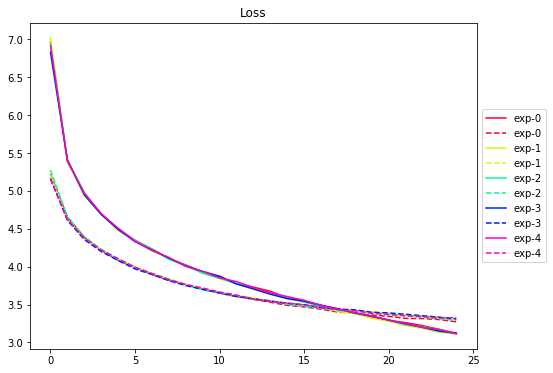

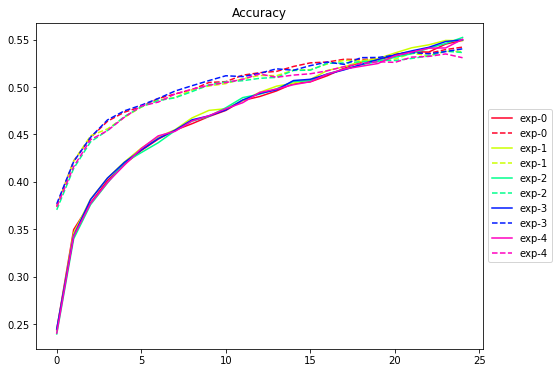

In [35]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()